# SARSA (Will evolve to Q-learning) experiment runner

In [3]:
%%capture
!pip install tqdm

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import numpy as np

from q_maze import QMaze, Action
from e_greedy_policy import EGreedyPolicy
from sarsa import Sarsa

from typing import Tuple

## Instantiate QMaze and EGreedyPolicy

In [5]:
qm = QMaze(20)
# Reminder that QMaze.reset only returns agent state now.
# Be careful to capture the state when resetting, because the 
# Agent/entrance will move!
state = qm.reset()
eg_policy = EGreedyPolicy(epsilon=0.999, decay=0.9)
sarsa = Sarsa(policy=eg_policy, environment=qm, gamma=0.9, alpha=0.01)


In [6]:
qm.display()

X X X X X X X X X X X X X X X X X X X X 
X . X X . X X X X X X . . . . . . A . X 
X . X . . . X X X X . . X . X X X . X X 
X . X X X . . X X . . X X . X . X X X X 
X . X X X . X X . . X X X X X . . X . X 
X . X . X . X X X . . . X X X . X X . X 
X . . . . . . . X . X . X . X . X . . X 
X X X . X X X X X . X X X . . . . . X X 
X X . . . . . . . . . X . . X . X X X X 
X . . X X . X X . X X X . X X X X X X X 
X X . . X . X X . . . . . . . . . . X X 
X X . X X X X X X X X X . X X . X . . X 
X . . . . X . . . . . X . . X . X . X X 
X . X X X X . X X X X X . X X X X . . X 
X . . . . . . . X X . X X X . X X X X X 
X . X . X . X . . . . . . . . . . . . X 
X . X X X X X X . X . X X X X X X X X X 
X . . . . X X . . X . X X X . X X X X X 
X . X . X X . . X X . . . . . . . . . X 
X X X X X X X X X X X X X X X X X X O X 



## One iteration to check policy is working with SARSA

12290


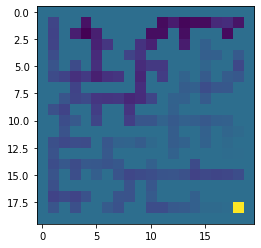

In [7]:
done = False
total_reward = 0

# TODO: We update epsilon here because actually I should have 
# made an Agent class, need to refactor to make this nicer...
while not done:
    action = eg_policy(state, sarsa.q_value_store)
    next_state, reward, done = qm.step(action)

    next_action = eg_policy(next_state, sarsa.q_value_store)
    
    action_index = action.value.index
    next_action_index = next_action.value.index
    
    sarsa.update_q_values(
        current_state=state,
        next_action=action_index,
        next_reward=reward,
        next_state=next_state,
        next_next_action=next_action_index
    )

    eg_policy.update_epsilon()
    state = next_state
    # print(reward)
    total_reward += reward

print(qm.turns_elapsed)
vals = sarsa.display_q_values()
plt.imshow((vals - vals.min())/(vals.max() - vals.min()))
plt.show()

In [8]:
# Transfer spike code to a nice function
def train_sarsa_for_one_episode(environment: QMaze, q_learning_method: Sarsa, policy: EGreedyPolicy) -> int:
    state = environment.reset()
    done = False
    total_reward = 0

    while not done:
        action = policy(state, q_learning_method.q_value_store)
        next_state, reward, done = environment.step(action)

        next_action = policy(next_state, q_learning_method.q_value_store)
        
        action_index = action.value.index
        next_action_index = next_action.value.index
        
        q_learning_method.update_q_values(
            current_state=state,
            next_action=action_index,
            next_reward=reward,
            next_state=next_state,
            next_next_action=next_action_index
        )

        policy.update_epsilon()
        state = next_state
        total_reward += reward

    return total_reward

## Now do it nicely for more episodes

In [9]:
def run_single_sarsa_exp(environment: QMaze, policy: EGreedyPolicy, q_values: np.ndarray) -> int:
    state = environment.reset()
    done = False

    total_reward = 0

    while not done:

        action = policy(state, q_values)
        state, reward, done = environment.step(action)

        total_reward += reward

    return total_reward
    
def run_sarsa_experiments(environment: QMaze, policy: EGreedyPolicy, q_learning_method: Sarsa, num_exp: int) -> Tuple[int, float, float, float]:
    all_rewards = []

    for _ in range(num_exp):

        final_reward = run_single_sarsa_exp(environment=environment, policy=policy, q_values=sarsa.q_value_store)
        all_rewards.append(final_reward)

    max_reward = max(all_rewards)
    mean_reward = np.mean(all_rewards)
    var_reward = np.std(all_rewards)

    return all_rewards, max_reward, mean_reward, var_reward

def run_sarsa_experiments_special(environment: QMaze, policy: EGreedyPolicy, q_learning_method: Sarsa, num_exp: int) -> Tuple[int, float, float, float]:
    all_rewards = []

    for _ in range(num_exp):

        final_reward = train_sarsa_for_one_episode(environment=environment, policy=policy, q_learning_method=sarsa)
        all_rewards.append(final_reward)

    max_reward = max(all_rewards)
    mean_reward = np.mean(all_rewards)
    var_reward = np.std(all_rewards)
    # policy.reset()

    return all_rewards, max_reward, mean_reward, var_reward


In [14]:
# # Set up parameters for the experiment
# qm = QMaze(10)
# eg_policy = EGreedyPolicy(epsilon=0.7, decay=0.9)
# sarsa = Sarsa(policy=eg_policy, environment=qm, gamma=0.9, alpha=0.01)
# num_episodes = tqdm(range(20))

# # Create structures to store data:
# all_all_rewards = []
# all_max_reward = []
# # all_mean_reward = []
# # all_var_reward = []

# for episode in num_episodes:

#     train_sarsa_for_one_episode(environment=qm, q_learning_method=sarsa, policy=eg_policy)

#     if (episode % 10) == 0:
#         all_rewards, max_reward, mean_reward, var_reward = run_sarsa_experiments(environment=qm, policy=eg_policy, q_learning_method=sarsa, num_exp=10)
#         # print('Episode: ', episode, ' ,epsilon: ',eg_policy.epsilon, ' , reward: ',  mean_reward, ' , var reward: ',  var_reward)
#         all_all_rewards.append(all_rewards)
#         all_max_reward.append(max_reward)
#         # all_mean_reward.append(mean_reward)
#         # all_var_reward.append(var_reward)
    
# vals = sarsa.display_q_values()
# plt.imshow((vals - vals.min())/(vals.max() - vals.min()))
# plt.show()

  0%|          | 0/20 [07:38<?, ?it/s]


KeyboardInterrupt: 

  0%|          | 0/1000 [00:00<?, ?it/s]X X X X X X X X X X 
X . . . . . . A . X 
X X X X X . X X X X 
X X X . . . . X X X 
X . X X . X . . . X 
X . . . . X . X X X 
X X X X . X . . . X 
X . . . . X . X X X 
X . X X . X . . . X 
X X X X X X X X O X 

{'maze_width': 10, 'maze_height': 10, 'size': 10, 'has_treasure': False, 'treasure_found': 0, 'treasure_left': 0, 'treasure_map': [], 'position_agent': (1, 7), 'position_entrance': (1, 7), 'position_exit': (9, 8), 'maze': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 2, 0, 1],
       [1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
       [1, 1, 1, 0, 0, 0, 0, 1, 1, 1],
       [1, 0, 1, 1, 0, 1, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 1, 0, 1, 1, 1],
       [1, 0, 1, 1, 0, 1, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 3, 1]]), 'generation_start_coords': (3, 6), 'generation_start_neighbours': [], 'turns_elapsed': 0, 'done': False, 'coord_to_index_state': array(

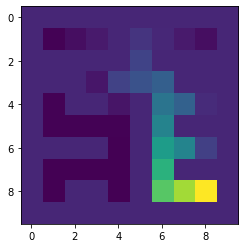

In [22]:
qm = QMaze(10)
qm.display(debug=True)
eg_policy = EGreedyPolicy(epsilon=0.7, decay=0.9)
sarsa = Sarsa(policy=eg_policy, environment=qm, gamma=0.9, alpha=0.01)
num_episodes = tqdm(range(1000))

# Create structures to store data:
all_all_rewards = []
all_max_reward = []
# all_mean_reward = []
# all_var_reward = []

for episode in num_episodes:

    # train_sarsa_for_one_episode(environment=qm, q_learning_method=sarsa, policy=eg_policy)

    if (episode % 10) == 0:
        all_rewards, max_reward, mean_reward, var_reward = run_sarsa_experiments_special(environment=qm, policy=eg_policy, q_learning_method=sarsa, num_exp=100)
        print('Episode: ', episode, ' ,starting epsilon: ',eg_policy.starting_epsilon,' ,epsilon: ',eg_policy.epsilon, ' , reward: ',  mean_reward, ' , var reward: ',  var_reward)
        all_all_rewards.append(all_rewards)
        all_max_reward.append(max_reward)
        # all_mean_reward.append(mean_reward)
        # all_var_reward.append(var_reward)
    
vals = sarsa.display_q_values()
plt.imshow((vals - vals.min())/(vals.max() - vals.min()))
plt.show()

In [17]:
# n_environments_per_size=5
# n_runs_per_environments=5
# gamma = 0.9

# mean_reward = []
# std_reward = []
    
# for size_envir in range(5,50,5):

#     # heuristics
#     n_improvement_steps = size_envir
#     n_steps_policy_eval = 10
    
#     total_rewards = []

#     for n_envir in range(n_environments_per_size):

#         dungeon = DungeonDP(size_envir)
#         policy = Policy(dungeon, gamma)
        
#         for n_improvements in range(n_improvement_steps):
    
#             policy.policy_iteration(n_steps_policy_eval)

#         all_total_rewards, _, _, _ = run_experiments(dungeon, policy, n_runs_per_environments)

#         total_rewards += all_total_rewards

#     mean_reward.append( np.mean(total_rewards) )
#     std_reward.append( np.std(total_rewards) )

# mean_reward = np.asarray(mean_reward)
# std_reward = np.asarray(std_reward)

# plt.plot(range(5, 50, 5), mean_reward, 'or')
# plt.plot(range(5, 50, 5), mean_reward, color = 'r')
# plt.fill_between(range(5, 50, 5), mean_reward - std_reward/2, mean_reward + std_reward/2,
#              color='r', alpha=0.2)

# plt.xlabel('Environment size')
# plt.ylabel('Average reward')

# plt.show()